# üìå Label Data : Localization ‚û°Ô∏è Segmentation
* Label DataÎ•º ÏïÑÎûò Ïù¥ÎØ∏ÏßÄÏôÄ Í∞ôÏù¥ Î≥ÄÍ≤ΩÌïòÍ≤å ÎêòÎ©¥ SegmentationÏùÑ ÏúÑÌïú Îç∞Ïù¥ÌÑ∞Î•º ÏôÑÏÑ±
* FracAtlas Îç∞Ïù¥ÌÑ∞Ïùò Í≥®Ï†à ÎùºÎ≤®ÎßÅÎêú Î∂ÄÎ∂ÑÏùÑ Î≥¥Î©¥ Í≥®Ï†à Î∂ÄÎ∂ÑÏùÑ Ï†ïÌôïÌûà ÎùºÎ≤®ÎßÅ Ìïú Í≤ÉÏù¥ ÏïÑÎãàÎùº Í∑∏ Ï£ºÎ≥ÄÏùÑ ÎùºÎ≤®ÎßÅ Ìï¥ ÎÜìÏïòÍ∏∞Ïóê Ïù¥ÏôÄ Í∞ôÏù¥ polygon Ïïà Ï™ΩÏùÑ Ï±ÑÏö¥ ÎùºÎ≤® Îç∞Ïù¥ÌÑ∞Î•º ÎßåÎì§Í≤å ÎêòÏóàÏùÑ Îïå Bounding Box Í∞ôÏùÄ Ï†ïÎ≥¥Î≥¥Îã§ Í≥®Ï†à Î∂ÄÎ∂ÑÏùÑ Îçî ÏÑ∏Î∞ÄÌïòÍ≤å Î†àÏù¥Î∏î ÌïòÍ≤å ÎêòÏñ¥ Í≥®Ï†àÏùÑ Ï∞æÎäî Îã§Îäî Î™©Ï†ÅÏóê Îçî Î∂ÄÌï©ÌïòÎã§Í≥† ÏÉùÍ∞ÅÌïòÏó¨ Ïù¥Î†áÍ≤å ÎùºÎ≤®ÎßÅÏùÑ ÏßÑÌñâÌïòÏòÄÏäµÎãàÎã§.

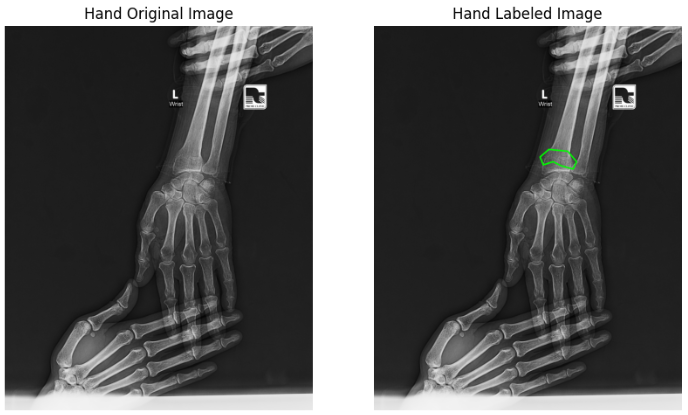
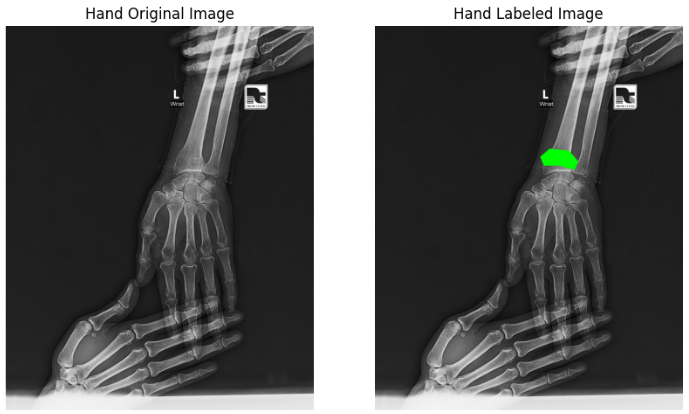



# 0. ÎùºÏù¥Î∏åÎü¨Î¶¨ Ìò∏Ï∂ú

In [1]:
import os
import cv2
import json
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# 1. ÎùºÎ≤®ÎßÅÏóê ÌïÑÏöîÌïú Function Íµ¨ÌòÑ

### 1-1. Ï†ÑÏ≤¥ Ïù¥ÎØ∏ÏßÄ ÌååÏùºÎ™ÖÏùÑ Í∞ñÎäî List ÏÉùÏÑ±

In [2]:
def get_image_names(image_folder):

    file_names = []

    for filename in os.listdir(image_folder):
        if filename.endswith('.jpg'):
            file_names.append(filename)

    file_names.sort()
    
    return file_names

### 1-2. VGG_fracture_mask.json ÌååÏùºÏùÑ json_data Î≥ÄÏàòÎ°ú ÏùΩÏñ¥Ïò¥.

In [3]:
def get_mask_in_json(json_folder):
    
    with open(json_folder, "r") as f:
        json_data = json.load(f)

    return json_data

### 1-3. get_polygon_coordinates
* VGG_fracture_mask.json ÌååÏùºÏóêÏÑú polygon Ï¢åÌëú Í∞ÄÏ†∏Ïò§Îäî ÏΩîÎìú

In [4]:
def get_polygon_coordinates(image_name, json_data):
    all_points_x_list = []
    all_points_y_list = []
    all_points = []

    for region in json_data[image_name]['regions'].values():
        all_points_x_list.append(region['shape_attributes']['all_points_x'])
        all_points_y_list.append(region['shape_attributes']['all_points_y'])

    for i in range(len(all_points_x_list)):
        all_points.append(np.array(list(zip(all_points_x_list[i], all_points_y_list[i])), np.int32))

    return all_points

### 1-4. fractured_fill_polygon Ìï®Ïàò
* polygon Ï¢åÌëúÎ•º ÌôúÏö©Ìï¥ÏÑú Ìïú Ïù¥ÎØ∏ÏßÄÏóê ÎåÄÌï¥ polygon ÎÇ¥Î∂ÄÎ•º Ï±ÑÏõåÏ§ÄÎã§.
* np.zerosÏóê fillpoly Ìï®ÏàòÎ•º ÌÜµÌï¥ ÎßåÎì† Ï¢åÌëúÎ•º Ï∞çÏñ¥Ï§ÄÎã§.
* Í∑∏Î†áÍ≤å ÌïòÏó¨ Í∞Å Ïù¥ÎØ∏ÏßÄÏóê ÎåÄÌïú mask Îç∞Ïù¥ÌÑ∞Î•º ÏñªÎäîÎã§.

In [5]:
def fractured_fill_polygon(image_name, polygon_coordinates):

    # maskÏùò ÏÇ¨Ïù¥Ï¶à ÌôïÏù∏
    image_path = "./data/images/Fractured/" + image_name
    
    with Image.open(image_path) as img:
        w, h = img.size
    
    # 0ÏúºÎ°ú Ï±ÑÏõåÏßÑ mask ÏÉùÏÑ±
    mask = np.zeros((h, w), dtype=np.uint8)
    
    # polygon Ï¢åÌëú ÏïàÏ™ΩÏùÑ 255Î°ú Ï±ÑÏö¥ mask ÏñªÏùå.
    cv2.fillPoly(mask, polygon_coordinates, color=255)
    
    return mask

### 1-5. non_fractured_zeros Ìï®Ïàò
* Ï†ïÏÉÅ Îç∞Ïù¥ÌÑ∞Îäî ÎùºÎ≤®Ïù¥ ÏóÜÍ≥† Í∞Å Ïù¥ÎØ∏ÏßÄÏùò ÏÇ¨Ïù¥Ï¶àÏóê ÎßûÎäî zerosÎ•º ÏÉùÏÑ±ÌïòÍ∏∞ ÏúÑÌïú ÏΩîÎìú

In [6]:
def non_fractured_zeros(image_name):

    image_path = "./data/images/Non_fractured/" + image_name
    
    with Image.open(image_path) as img:
        w, h = img.size

    mask = np.zeros((h, w), dtype=np.uint8)

    return mask

# 2. main code

### 2-1. Fracture, Non_fracture dataÏùò ÎùºÎ≤®ÏùÑ Í∞ñÎäî maskÎ•º ÏÉùÏÑ± ÏôÑÎ£å

In [7]:
non_fractured_file_names = get_image_names('./data/images/Non_fractured')
fractured_file_names = get_image_names('./data/images/Fractured')
json_data = get_mask_in_json("./data/VGG_fracture_masks.json")

non_fractured_mask_list = []
fractured_mask_list = []

for i in non_fractured_file_names:
    mask = non_fractured_zeros(i)
    non_fractured_mask_list.append(mask)
    
for i in fractured_file_names:
    mask = fractured_fill_polygon(i, get_polygon_coordinates(i, json_data))
    fractured_mask_list.append(mask)

### 2-2. fractured_mask Îç∞Ïù¥ÌÑ∞Î•º npy Ï†ÄÏû•

In [37]:
mask_data_array = np.array(fractured_mask_list, dtype=object)
np.save('Fractured_mask', mask_data_array)

Fractured_mask = np.load("./Fractured_mask.npy", allow_pickle=True)

Fractured_mask.shape

(717,)

### 2-3. fractured_mask Îç∞Ïù¥ÌÑ∞Î•º (240, 240)ÏúºÎ°ú resizeÌï¥ÏÑú npyÎ°ú Ï†ÄÏû•

In [39]:
mask_data_array = np.array(fractured_mask_list, dtype=object)

resized_masks = np.array([cv2.resize(mask, (240, 240)) for mask in mask_data_array])
np.save('Fractured_mask_240', resized_masks)

Fractured_mask_240 = np.load("./Fractured_mask_240.npy")

Fractured_mask_240.shape

(717, 240, 240)

# 3. Îç∞Ïù¥ÌÑ∞ ÌôïÏù∏

### 3-1. jpgÏù∏ Fracture dataÎ•º npyÎ°ú Î≥ÄÍ≤Ω
* plt.imshowÎ°ú ÏãúÍ∞ÅÌôî ÌïòÍ∏∞ ÏúÑÌï¥ÏÑú

In [42]:
import os
import cv2
import numpy as np

image_folder = './data/images/Fractured'
output_file = 'Fractured'

image_data = []

# ÌååÏùº Î™©Î°ùÏùÑ Ïò§Î¶ÑÏ∞®ÏàúÏúºÎ°ú Ï†ïÎ†¨ÌïòÏó¨ Í∞ÄÏ†∏Ïò§Í∏∞
for filename in sorted(os.listdir(image_folder)):
    if filename.endswith('.jpg'):
        img_path = os.path.join(image_folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            image_data.append(img)

# Î¶¨Ïä§Ìä∏Î•º NumPy Î∞∞Ïó¥Î°ú Î≥ÄÌôòÌïòÏó¨ Ï†ÄÏû•
image_data_array = np.array(image_data, dtype=object)
np.save(output_file, image_data_array)  # npy ÌååÏùºÎ°ú Ï†ÄÏû•

# npy Îç∞Ïù¥ÌÑ∞ load ÌõÑ shape Ï∂úÎ†•
Fractured = np.load("./Fractured.npy", allow_pickle=True)

Fractured.shape

(717,)

### 3-2. Fractured dataÎ•º (240, 240)ÏúºÎ°ú resize Ìï¥ÏÑú npyÎ°ú Î≥ÄÍ≤Ω

In [41]:
import os
import cv2
import numpy as np

image_folder = './data/images/Fractured'
output_file = 'Fractured_240'

image_data = []

# ÌååÏùº Î™©Î°ùÏùÑ Ïò§Î¶ÑÏ∞®ÏàúÏúºÎ°ú Ï†ïÎ†¨ÌïòÏó¨ Í∞ÄÏ†∏Ïò§Í∏∞
for filename in sorted(os.listdir(image_folder)):
    if filename.endswith('.jpg'):
        img_path = os.path.join(image_folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img_resized = cv2.resize(img, (240, 240))
        image_data.append(img_resized)
        
# Î¶¨Ïä§Ìä∏Î•º NumPy Î∞∞Ïó¥Î°ú Î≥ÄÌôòÌïòÏó¨ Ï†ÄÏû•
image_data_array = np.array(image_data)
np.save(output_file, image_data_array)  # npy ÌååÏùºÎ°ú Ï†ÄÏû•

# npy Îç∞Ïù¥ÌÑ∞ load ÌõÑ shape Ï∂úÎ†•
Fractured_240 = np.load("./Fractured_240.npy")

Fractured_240.shape

(717, 240, 240)

### 3-3. image, label, overlap ÏãúÍ∞ÅÌôî
* ÏõêÎ≥∏ Ïù¥ÎØ∏ÏßÄÏóê ÏúÑÏóêÏÑú ÎßåÎì† ÎùºÎ≤®ÏùÑ Í≤πÏπú Ïù¥ÎØ∏ÏßÄÎ•º ÏãúÍ∞ÅÌôî

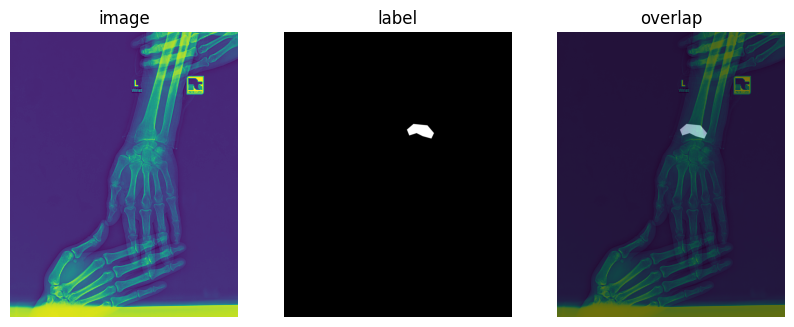

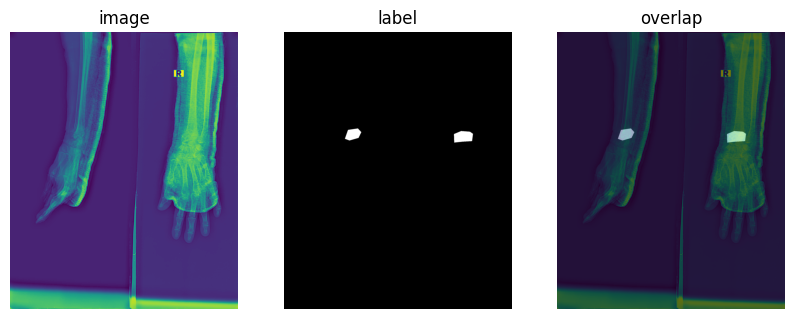

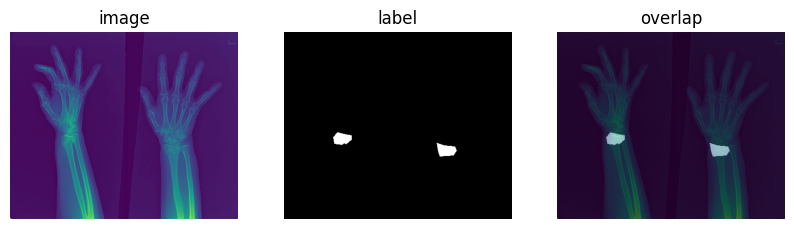

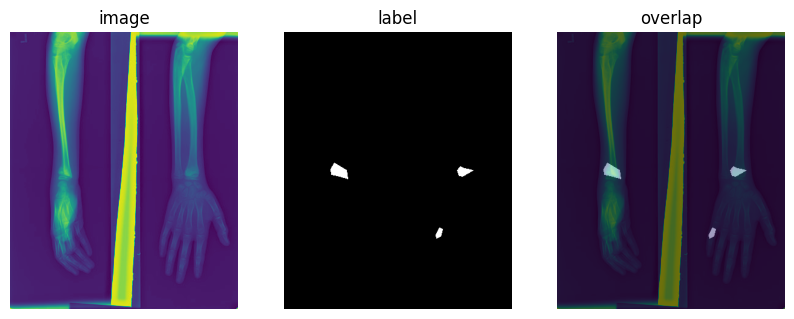

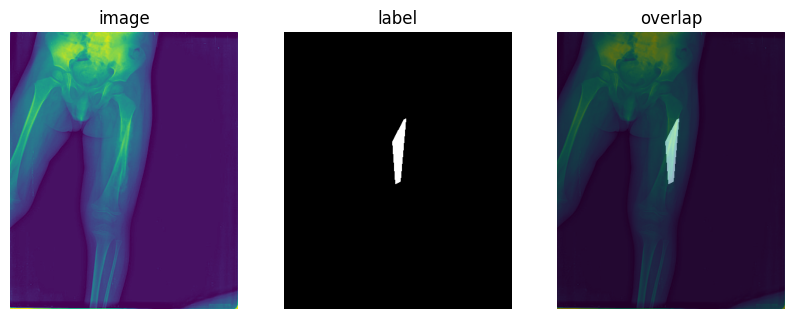

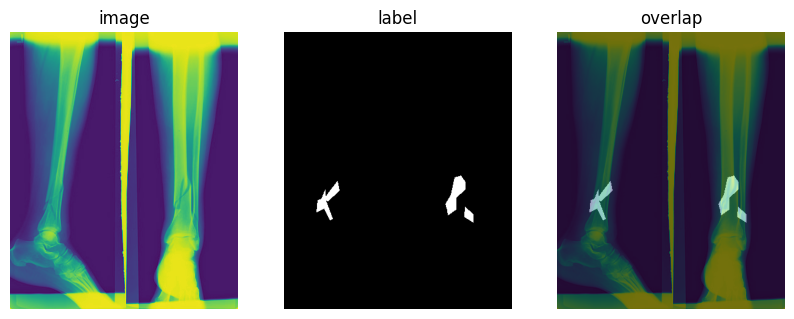

In [9]:
import matplotlib.pyplot as plt

num_list = [0, 19, 20, 21, 391, 424]

for num in num_list:
    plt.figure(figsize=(10, 5))
    
    # ÏõêÎ≥∏ Ïù¥ÎØ∏ÏßÄ
    plt.subplot(131)
    plt.imshow(Fractured[num])
    plt.title("image")
    plt.axis("off")
    
    # ÎßàÏä§ÌÅ¨ Ïù¥ÎØ∏ÏßÄ
    plt.subplot(132)
    plt.imshow(fractured_mask_list[num], cmap='gray')
    plt.title("label")
    plt.axis("off")
    
    # Í≤πÏ≥êÎ≥¥Í∏∞ (overlap)
    plt.subplot(133)
    plt.imshow(fractured_mask_list[num], cmap='gray')
    plt.title("overlap")
    plt.axis("off")
    plt.imshow(Fractured[num], alpha=0.5)
    
    plt.show()
